# Detectando e Interpretando Sinais Periódicos em Séries Temporais Paleobiológicas

## Análise Espectral de Diversidade de Gêneros Marinhos

**Disciplina:** CCM0228 - Computação IV (2025.1)  
**Autores:**
- Helena Baptista Reis (NUSP: 14577622)
- Luca Marinho Nasser Valadares Paiva (NUSP: 13691375)

---

### Resumo do Projeto

Este notebook implementa uma análise espectral rigorosa para detectar e interpretar sinais periódicos em séries temporais paleobiológicas. Utilizamos dados de diversidade de gêneros marinhos ao longo do tempo geológico para investigar padrões cíclicos que podem estar relacionados a processos geológicos, climáticos ou astronômicos.

### Metodologia

1. **Pré-processamento:** Remoção de tendências de longo prazo
2. **Análise Espectral:** Transformada de Fourier (FFT) com padding
3. **Testes Estatísticos:** Modelos nulos de Monte Carlo
4. **Validação:** Critérios de significância rigorosos

### Organização do Código

O código está organizado em blocos funcionais modulares para máxima reutilização e clareza:
- **Configuração e Dependências**
- **Funções de Processamento de Dados**
- **Funções de Análise Espectral**
- **Funções de Visualização**
- **Módulo de Modelos Nulos**
- **Módulo de Testes de Significância**
- **Pipeline de Análise Principal**

In [ ]:
# ============================
# CONFIGURAÇÃO E DEPENDÊNCIAS
# ============================

# Imports padrão
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imports científicos
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq

# Configuração de caminhos
DATA_ROOT = Path("data")
GENERA_DATA_PATH = DATA_ROOT / "raw" / "genera_data.csv"
RESULTS_PATH = DATA_ROOT / "processed"

# Configuração de plotagem
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Configuração de seeds para reprodutibilidade
np.random.seed(42)

✓ Dependências carregadas
✓ Diretório de dados: /home/luca/Detectando-e-Interpretando-Sinais-Periodicos-em-Series-Temporais-Paleobiologicas/data
✓ Diretório de resultados: /home/luca/Detectando-e-Interpretando-Sinais-Periodicos-em-Series-Temporais-Paleobiologicas/data/processed
✓ Configuração concluída


In [128]:
# ============================
# MÓDULO: PROCESSAMENTO DE DADOS
# ============================

def carregar_dados(caminho_arquivo):
    """
    Carrega dados de diversidade paleobiológica.
    
    Returns: (DataFrame, tempo, diversidade normalizada)
    """
    try:
        df = pd.read_csv(caminho_arquivo)
        x = df["TimeBin"].values
        y = (df["Diversity"] / 1000).values  # Conversão para milhares
        
        print(f"✓ Dados: {len(df)} pontos, {x.min():.0f}-{x.max():.0f} Myr, {y.min():.2f}-{y.max():.2f} mil gêneros")
        return df, x, y
    except Exception as e:
        raise ValueError(f"Erro ao carregar dados: {e}")

def ajustar_polinomio(y, grau=3, metodo='polyfit'):
    """
    Ajusta polinômio para remoção de tendência.
    
    Args:
        y: Série temporal
        grau: Grau do polinômio (default=3)
        metodo: 'polyfit' ou 'lstsq'
    
    Returns: Função polinomial ajustada
    """
    x_norm = np.arange(len(y))
    
    if metodo == 'polyfit':
        coeficientes = np.polyfit(x_norm, y, grau)
    elif metodo == 'lstsq':
        A = np.vander(x_norm, grau + 1)
        coeficientes, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    else:
        raise ValueError(f"Método '{metodo}' não reconhecido")
    
    polynomial = np.poly1d(coeficientes)
    
    # R² para avaliação
    y_pred = polynomial(x_norm)
    r2 = 1 - (np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2))
    
    print(f"✓ Polinômio grau {grau} ajustado (R² = {r2:.3f})")
    return polynomial

def calcular_residuos(y, x, polynomial):
    """
    Remove tendência calculando resíduos centrados em zero.
    
    Returns: Série de resíduos (dados - tendência)
    """
    x_indices = np.arange(len(y))
    tendencia = polynomial(x_indices)
    residuos = y - tendencia
    
    print(f"✓ Resíduos: média={np.mean(residuos):.4f}, std={np.std(residuos):.4f}, amplitude={np.ptp(residuos):.4f}")
    return residuos

def calcular_espectro_potencia(series, pad=1, janela=None):
    """
    Calcula espectro de potência via FFT.
    
    Args:
        series: Série temporal
        pad: Fator de zero-padding (default=1)
        janela: Tipo de janela ('hann', 'hamming', 'blackman', None)
    
    Returns: (frequências positivas, potências normalizadas)
    """
    N = len(series)
    N_pad = pad * N
    
    # Aplicar janelamento se especificado
    if janela is not None:
        if janela == 'hann':
            window = np.hanning(N)
        elif janela == 'hamming':
            window = np.hamming(N)
        elif janela == 'blackman':
            window = np.blackman(N)
        else:
            raise ValueError(f"Janela '{janela}' não suportada")
        
        series_janelada = series * window
        normalizacao = np.sqrt(np.mean(window**2))
        series_janelada /= normalizacao
    else:
        series_janelada = series.copy()
    
    # Zero-padding e FFT
    series_padded = np.pad(series_janelada, (0, N_pad - N), 'constant')
    freqs = fftfreq(len(series_padded))
    fft_vals = fft(series_padded)
    potencia = (np.abs(fft_vals) / len(series_padded))**2
    
    # Filtrar frequências positivas e relevantes (0 < f < 0.05)
    mask = (freqs > 0) & (freqs < 0.05)
    freqs_positivas = freqs[mask]
    potencias_positivas = potencia[mask]
    
    print(f"✓ Espectro: {len(freqs_positivas)} pontos, padding {pad}x, janela {janela or 'nenhuma'}")
    return freqs_positivas, potencias_positivas

def identificar_picos_espectrais(freqs, pots, threshold_frac=0.25, min_distance_frac=0.02):
    """
    Identifica picos estatisticamente relevantes.
    
    Args:
        freqs: Frequências
        pots: Potências
        threshold_frac: Fração da potência máxima (default=0.25)
        min_distance_frac: Distância mínima entre picos (default=0.02)
    
    Returns: (índices dos picos, propriedades, threshold)
    """
    threshold = np.max(pots) * threshold_frac
    freq_range = freqs[-1] - freqs[0]
    min_distance_freq = freq_range * min_distance_frac
    min_distance_indices = int(min_distance_freq / (freqs[1] - freqs[0]))
    
    picos, properties = find_peaks(pots, height=threshold, distance=max(min_distance_indices, 1))
    
    print(f"\n✓ Picos encontrados: {len(picos)} (threshold {int(threshold_frac*100)}%)")
    for i, idx in enumerate(picos, 1):
        periodo = 1 / freqs[idx]
        print(f"  {i}. Período: {periodo:6.1f} Myr | Potência: {pots[idx]:.6f}")
    
    return picos, properties, threshold

# ============================
# MÓDULO: TESTES DE SIGNIFICÂNCIA
# ============================

def calcular_significancia_picos(freqs_original, pots_original, picos, todos_espectros_nulos, freqs_nulos):
    """
    Calcula significância estatística dos picos via percentis.
    
    Args:
        freqs_original, pots_original: Espectro original
        picos: Índices dos picos identificados
        todos_espectros_nulos: Array com espectros do modelo nulo
        freqs_nulos: Frequências do modelo nulo
    
    Returns: Lista de dicionários com resultados para cada pico
    """
    resultados = []
    
    for i, pico_idx in enumerate(picos):
        freq_pico = freqs_original[pico_idx]
        pot_pico = pots_original[pico_idx]
        periodo = 1 / freq_pico
        
        # Encontrar índice correspondente no espectro nulo
        idx_nulo = np.argmin(np.abs(freqs_nulos - freq_pico))
        pots_nulas = todos_espectros_nulos[:, idx_nulo]
        
        # Calcular percentil e significância
        percentil = np.sum(pots_nulas >= pot_pico) / len(pots_nulas) * 100
        significancia = 100 - percentil
        
        resultado = {
            'periodo': periodo,
            'frequencia': freq_pico,
            'potencia': pot_pico,
            'percentil': percentil,
            'significancia': significancia,
            'significativo': significancia >= 95  # 95% de confiança
        }
        
        resultados.append(resultado)
        
        print(f"Pico {i+1}: Período = {periodo:.1f} Myr")
        print(f"  Potência observada: {pot_pico:.6f}")
        print(f"  Percentil no modelo nulo: {percentil:.1f}%")
        print(f"  Significância: {significancia:.1f}%")
        print(f"  Significativo (95%): {'Sim' if resultado['significativo'] else 'Não'}")
        print()
    
    return resultados

def comparar_modelos_nulos(freqs_original, pots_original, picos, 
                          todos_espectros_r, freqs_r,
                          todos_espectros_w, freqs_w):
    """
    Compara significância dos picos entre modelos R e W.
    
    Returns: (resultados_r, resultados_w)
    """
    print("=== COMPARAÇÃO DE SIGNIFICÂNCIA ENTRE MODELOS ===")
    print()
    
    # Calcular significância para ambos modelos
    print("MODELO R (Embaralhamento de Incrementos):")
    print("-" * 50)
    resultados_r = calcular_significancia_picos(freqs_original, pots_original, picos, 
                                               todos_espectros_r, freqs_r)
    
    print("MODELO W (Embaralhamento de Blocos):")
    print("-" * 50)
    resultados_w = calcular_significancia_picos(freqs_original, pots_original, picos, 
                                               todos_espectros_w, freqs_w)
    
    # Resumo comparativo
    print("=== RESUMO COMPARATIVO ===")
    print(f"{'Período (Myr)':<12} {'Modelo R (%)':<12} {'Modelo W (%)':<12} {'Consenso':<10}")
    print("-" * 50)
    
    for i in range(len(resultados_r)):
        periodo = resultados_r[i]['periodo']
        sig_r = resultados_r[i]['significancia']
        sig_w = resultados_w[i]['significancia']
        consenso = 'Sim' if (sig_r >= 95 and sig_w >= 95) else 'Não'
        
        print(f"{periodo:<12.1f} {sig_r:<12.1f} {sig_w:<12.1f} {consenso:<10}")
    
    return resultados_r, resultados_w

def criar_relatorio_final(resultados_r, resultados_w):
    """
    Cria relatório final da análise com picos significativos.
    
    Returns: Lista de picos significativos em ambos os modelos
    """
    print("\n" + "=" * 60)
    print("RELATÓRIO FINAL DA ANÁLISE ESPECTRAL")
    print("=" * 60)
    
    # Picos significativos em ambos os modelos
    picos_significativos = []
    for i in range(len(resultados_r)):
        if resultados_r[i]['significativo'] and resultados_w[i]['significativo']:
            picos_significativos.append({
                'periodo': resultados_r[i]['periodo'],
                'sig_r': resultados_r[i]['significancia'],
                'sig_w': resultados_w[i]['significancia']
            })
    
    print(f"\nPicos identificados: {len(resultados_r)}")
    print(f"Picos significativos (ambos modelos): {len(picos_significativos)}")
    
    if picos_significativos:
        print("\nPICOS SIGNIFICATIVOS CONFIRMADOS:")
        print("-" * 40)
        for pico in picos_significativos:
            print(f"Período: {pico['periodo']:.1f} Myr (R: {pico['sig_r']:.1f}%, W: {pico['sig_w']:.1f}%)")
    else:
        print("\nNenhum pico foi considerado significativo em ambos os modelos.")
    
    print("\nCONCLUSÃO:")
    print("-" * 20)
    if picos_significativos:
        print(f"A análise espectral identificou {len(picos_significativos)} padrão(s) periódico(s)")
        print("estatisticamente significativo(s) na série temporal de diversidade.")
        if len(picos_significativos) == 1:
            periodo = picos_significativos[0]['periodo']
            print(f"O período dominante é de aproximadamente {periodo:.0f} Myr.")
    else:
        print("Não foram encontrados padrões periódicos estatisticamente significativos")
        print("na série temporal analisada.")
    
    return picos_significativos

In [130]:
# ============================
# MÓDULO: VISUALIZAÇÃO
# ============================

def plotar_serie_temporal(x, y, titulo, nome_arquivo, polynomial=None, residuals=None, config_plot=None):
    """
    Plota séries temporais com opções avançadas.
    
    Args:
        x, y: Dados temporais
        titulo: Título do gráfico
        nome_arquivo: Nome para salvar
        polynomial: Função polinomial (opcional)
        residuals: Série de resíduos (opcional)
        config_plot: Configurações customizadas (opcional)
    
    Returns: (figura, eixos)
    """
    # Configurações padrão
    default_config = {
        'figsize': (12, 8),
        'xlim': (0, 542), 'xticks': np.arange(0, 542, 100),
        'ylim': (-1, 5.5), 'yticks': np.arange(0, 6),
        'cores': {'serie': 'black', 'tendencia': 'red', 'residuos': 'blue'},
        'estilos': {
            'serie': {'linewidth': 0.8, 'alpha': 0.8},
            'tendencia': {'linewidth': 1.2, 'linestyle': '-'},
            'residuos': {'linewidth': 0.8, 'alpha': 0.7}
        }
    }
    
    if config_plot:
        for key, value in config_plot.items():
            if isinstance(value, dict) and key in default_config:
                default_config[key].update(value)
            else:
                default_config[key] = value
    
    config = default_config
    
    # Criar figura e plot principal
    fig, ax = plt.subplots(figsize=config['figsize'])
    ax.stairs(y, linewidth=config['estilos']['serie']['linewidth'], 
             color=config['cores']['serie'], alpha=config['estilos']['serie']['alpha'],
             label="Série Temporal")
    
    # Adicionar tendência se fornecida
    if polynomial is not None:
        x_indices = np.arange(len(y))
        y_trend = polynomial(x_indices)
        ax.plot(x, y_trend, color=config['cores']['tendencia'], 
               linewidth=config['estilos']['tendencia']['linewidth'],
               linestyle=config['estilos']['tendencia']['linestyle'],
               label="Tendência (grau 3)")
    
    # Adicionar resíduos se fornecidos
    if residuals is not None:
        ax.plot(x, residuals, color=config['cores']['residuos'], 
               linewidth=config['estilos']['residuos']['linewidth'],
               alpha=config['estilos']['residuos']['alpha'], label="Resíduos")
    
    # Configurações finais
    ax.set(xlim=config['xlim'], xticks=config['xticks'],
           ylim=config['ylim'], yticks=config['yticks'],
           xlabel="Idade (Myr)", ylabel="Diversidade (milhares de gêneros)", title=titulo)
    
    if polynomial is not None or residuals is not None:
        ax.legend(loc="upper right", framealpha=0.9)
    
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(str(RESULTS_PATH / nome_arquivo), dpi=300, bbox_inches="tight")
    plt.show()
    
    print(f"✓ Gráfico salvo: {nome_arquivo}")
    return fig, ax

def plotar_espectro_potencia(freqs, pots, titulo, nome_arquivo, picos=None, threshold=None, 
                           freqs_modelo=None, pots_modelo=None, intervalo_confianca=None, config_plot=None):
    """
    Plota espectros de potência com modelos nulos e picos.
    
    Args:
        freqs, pots: Dados espectrais
        titulo: Título do gráfico
        nome_arquivo: Nome para salvar
        picos: Índices dos picos (opcional)
        threshold: Valor do threshold (opcional)
        freqs_modelo, pots_modelo: Dados do modelo nulo (opcional)
        intervalo_confianca: (percentil_5, percentil_95) (opcional)
        config_plot: Configurações customizadas (opcional)
    
    Returns: (figura, eixos)
    """
    # Configurações padrão
    default_config = {
        'figsize': (14, 10),
        'cores': {'original': 'blue', 'modelo': 'red', 'intervalo': 'red', 'picos': 'red', 'threshold': 'red'},
        'estilos': {
            'original': {'linewidth': 1.5, 'alpha': 0.8},
            'modelo': {'linewidth': 2, 'linestyle': '--'},
            'intervalo': {'alpha': 0.3},
            'threshold': {'linestyle': '--', 'alpha': 0.7}
        }
    }
    
    if config_plot:
        for key, value in config_plot.items():
            if isinstance(value, dict) and key in default_config:
                default_config[key].update(value)
            else:
                default_config[key] = value
    
    config = default_config
    
    # Criar figura e plot principal
    fig, ax = plt.subplots(figsize=config['figsize'])
    ax.plot(freqs, pots, color=config['cores']['original'],
           linewidth=config['estilos']['original']['linewidth'],
           alpha=config['estilos']['original']['alpha'], label='Espectro Original')
    
    # Adicionar modelo nulo
    if freqs_modelo is not None and pots_modelo is not None:
        ax.plot(freqs_modelo, pots_modelo, color=config['cores']['modelo'],
               linewidth=config['estilos']['modelo']['linewidth'],
               linestyle=config['estilos']['modelo']['linestyle'],
               label='Espectro Médio Modelo Nulo')
    
    # Adicionar intervalo de confiança
    if intervalo_confianca is not None:
        percentil_5, percentil_95 = intervalo_confianca
        ax.fill_between(freqs, percentil_5, percentil_95, 
                       alpha=config['estilos']['intervalo']['alpha'], 
                       color=config['cores']['intervalo'], label='Intervalo 90% (5%-95%)')
    
    # Adicionar picos
    if picos is not None and len(picos) > 0:
        ax.plot(freqs[picos], pots[picos], 'ro', markersize=8, 
               markerfacecolor=config['cores']['picos'], markeredgecolor='white',
               markeredgewidth=1, label='Picos Identificados')
        
        # Anotar períodos
        for i in picos:
            periodo = 1 / freqs[i]
            ax.annotate(f'{periodo:.0f} Myr', (freqs[i], pots[i]),
                       textcoords="offset points", xytext=(0, 10), ha='center', 
                       fontsize=9, fontweight='bold', color=config['cores']['picos'],
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                edgecolor=config['cores']['picos'], alpha=0.8))
    
    # Adicionar threshold
    if threshold is not None:
        threshold_pct = int((threshold / np.max(pots)) * 100)
        ax.axhline(y=threshold, color=config['cores']['threshold'], 
                  linestyle=config['estilos']['threshold']['linestyle'],
                  alpha=config['estilos']['threshold']['alpha'],
                  label=f'Threshold de {threshold_pct}%')
    
    # Configurações finais
    ax.set(xlim=(0, 0.05), ylim=(0, np.max(pots) * 1.1), xticks=np.arange(0, 0.06, 0.01),
           xlabel='Frequência (ciclos Myr⁻¹)', ylabel='Potência espectral', title=titulo)
    
    ax.legend(loc='upper right', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle=':')
    plt.tight_layout()
    plt.savefig(str(RESULTS_PATH / nome_arquivo), dpi=300, bbox_inches="tight")
    plt.show()
    
    print(f"✓ Espectro salvo: {nome_arquivo}")
    return fig, ax

def criar_dashboard_completo(dados_dict, nome_arquivo="dashboard_completo.png"):
    """
    Cria dashboard integrado com múltiplos painéis.
    
    Args:
        dados_dict: Dicionário com todos os dados necessários
        nome_arquivo: Nome do arquivo para salvar
    
    Returns: (figura, eixos)
    """
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1],
                         hspace=0.3, wspace=0.3)
    
    # 1. Série temporal original
    ax1 = fig.add_subplot(gs[0, :])
    x, y = dados_dict['x'], dados_dict['y']
    ax1.stairs(y, linewidth=1, color='black', alpha=0.8)
    ax1.set_title('Série Temporal de Diversidade', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Idade (Myr)')
    ax1.set_ylabel('Diversidade (mil gêneros)')
    ax1.grid(True, alpha=0.3)
    
    # 2. Série com tendência removida
    ax2 = fig.add_subplot(gs[1, 0])
    if 'residuos' in dados_dict:
        ax2.plot(x, dados_dict['residuos'], 'b-', linewidth=1, alpha=0.8)
        ax2.set_title('Resíduos (Tendência Removida)')
        ax2.set_xlabel('Idade (Myr)')
        ax2.set_ylabel('Resíduos')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # 3. Espectro de potência
    ax3 = fig.add_subplot(gs[1, 1])
    if 'freqs' in dados_dict and 'pots' in dados_dict:
        freqs, pots = dados_dict['freqs'], dados_dict['pots']
        ax3.plot(freqs, pots, 'b-', linewidth=1.5)
        ax3.set_title('Espectro de Potência')
        ax3.set_xlabel('Frequência (ciclos/Myr)')
        ax3.set_ylabel('Potência')
        ax3.grid(True, alpha=0.3)
        
        if 'picos' in dados_dict:
            picos = dados_dict['picos']
            ax3.plot(freqs[picos], pots[picos], 'ro', markersize=6)
    
    # 4. Comparação com modelos nulos
    ax4 = fig.add_subplot(gs[2, :])
    if all(k in dados_dict for k in ['freqs', 'pots', 'freqs_r', 'pots_r']):
        ax4.plot(freqs, pots, 'b-', linewidth=1.5, label='Original', alpha=0.8)
        ax4.plot(dados_dict['freqs_r'], dados_dict['pots_r'], 'r--', linewidth=1.2, label='Modelo R')
        
        if 'freqs_w' in dados_dict and 'pots_w' in dados_dict:
            ax4.plot(dados_dict['freqs_w'], dados_dict['pots_w'], 'g--', linewidth=1.2, label='Modelo W')
        
        ax4.set_title('Comparação com Modelos Nulos')
        ax4.set_xlabel('Frequência (ciclos/Myr)')
        ax4.set_ylabel('Potência')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Dashboard de Análise Espectral Paleobiológica', fontsize=16, fontweight='bold', y=0.95)
    plt.savefig(str(RESULTS_PATH / nome_arquivo), dpi=300, bbox_inches="tight")
    plt.show()
    
    print(f"✓ Dashboard salvo: {nome_arquivo}")
    return fig, (ax1, ax2, ax3, ax4)

In [131]:
# ============================
# MÓDULO: MODELOS NULOS (MONTE CARLO)
# ============================

def modelo_r(series, n_simulacoes=1000, verbose=True):
    """
    Modelo R (Red Noise): Embaralhamento de incrementos.
    Simula passeio aleatório preservando distribuição dos incrementos.
    
    Args:
        series: Série temporal original
        n_simulacoes: Número de simulações Monte Carlo
        verbose: Mostrar progresso
    
    Returns: Lista de séries simuladas
    """
    incrementos = np.diff(series)
    series_simuladas = []
    
    if verbose:
        print(f"🔄 Modelo R: {n_simulacoes} simulações")
        print(f"   Incrementos: {len(incrementos)}, média={np.mean(incrementos):.4f}, std={np.std(incrementos):.4f}")
    
    for i in range(n_simulacoes):
        if verbose and (i + 1) % 200 == 0:
            print(f"   • Progresso: {i + 1}/{n_simulacoes} ({(i+1)/n_simulacoes*100:.1f}%)")
        
        # Embaralhar incrementos e reconstruir série
        incrementos_embaralhados = np.random.permutation(incrementos)
        serie_simulada = np.zeros(len(series))
        serie_simulada[0] = series[0]
        
        for j in range(1, len(series)):
            serie_simulada[j] = serie_simulada[j-1] + incrementos_embaralhados[j-1]
        
        series_simuladas.append(serie_simulada)
    
    if verbose:
        print(f"   ✓ Modelo R concluído: {len(series_simuladas)} simulações")
    
    return series_simuladas

def modelo_w(series, tamanho_bloco=10, n_simulacoes=1000, verbose=True):
    """
    Modelo W (White Noise): Embaralhamento de blocos.
    Preserva autocorrelações locais mas remove estruturas de longo prazo.
    
    Args:
        series: Série temporal original
        tamanho_bloco: Tamanho dos blocos contíguos
        n_simulacoes: Número de simulações Monte Carlo
        verbose: Mostrar progresso
    
    Returns: Lista de séries simuladas
    """
    series_simuladas = []
    n_pontos = len(series)
    n_blocos = int(np.ceil(n_pontos / tamanho_bloco))
    
    if verbose:
        print(f"🔄 Modelo W: {n_simulacoes} simulações")
        print(f"   Bloco: {tamanho_bloco}, Blocos: {n_blocos}, Pontos: {n_pontos}")
    
    for i in range(n_simulacoes):
        if verbose and (i + 1) % 200 == 0:
            print(f"   • Progresso: {i + 1}/{n_simulacoes} ({(i+1)/n_simulacoes*100:.1f}%)")
        
        # Dividir em blocos e embaralhar
        blocos = []
        for j in range(0, n_pontos, tamanho_bloco):
            fim = min(j + tamanho_bloco, n_pontos)
            blocos.append(series[j:fim])
        
        blocos_embaralhados = blocos.copy()
        np.random.shuffle(blocos_embaralhados)
        
        # Reconstruir série
        serie_simulada = np.concatenate(blocos_embaralhados)[:n_pontos]
        series_simuladas.append(serie_simulada)
    
    if verbose:
        print(f"   ✓ Modelo W concluído: {len(series_simuladas)} simulações")
    
    return series_simuladas

def calcular_espectros_modelos_nulos(series_simuladas, pad=7, verbose=True):
    """
    Calcula espectros de potência para séries simuladas.
    Cada série é processada com remoção de tendência antes do cálculo espectral.
    
    Args:
        series_simuladas: Lista de séries simuladas
        pad: Fator de padding para FFT
        verbose: Mostrar progresso
    
    Returns: (array de espectros, frequências comuns)
    """
    espectros_pots = []
    freqs_comum = None
    
    if verbose:
        print(f"📊 Calculando espectros: {len(series_simuladas)} séries (padding {pad}x)")
    
    for i, serie in enumerate(series_simuladas):
        if verbose and (i + 1) % 200 == 0:
            print(f"   • Processando: {i + 1}/{len(series_simuladas)} ({(i+1)/len(series_simuladas)*100:.1f}%)")
        
        try:
            # Remover tendência e calcular espectro
            polynomial_sim = ajustar_polinomio(serie, grau=3, metodo='polyfit')
            residuals_sim = calcular_residuos(serie, np.arange(len(serie)), polynomial_sim)
            freqs, pots = calcular_espectro_potencia(residuals_sim, pad=pad)
            
            if freqs_comum is None:
                freqs_comum = freqs.copy()
            
            espectros_pots.append(pots)
            
        except Exception as e:
            if verbose:
                print(f"   ⚠️ Erro na simulação {i+1}: {e}")
            continue
    
    if verbose:
        print(f"   ✓ Espectros calculados: {len(espectros_pots)} válidos")
        if len(espectros_pots) < len(series_simuladas):
            print(f"   ⚠️ {len(series_simuladas) - len(espectros_pots)} simulações falharam")
    
    return np.array(espectros_pots), freqs_comum

def calcular_estatisticas_modelos_nulos(espectros_pots, percentis=[5, 50, 95]):
    """
    Calcula estatísticas descritivas dos espectros.
    
    Args:
        espectros_pots: Array com espectros (n_simulacoes x n_frequencias)
        percentis: Percentis a calcular
    
    Returns: Dicionário com estatísticas
    """
    if len(espectros_pots) == 0:
        raise ValueError("Nenhum espectro válido fornecido")
    
    estatisticas = {
        'media': np.mean(espectros_pots, axis=0),
        'desvio_padrao': np.std(espectros_pots, axis=0),
        'mediana': np.median(espectros_pots, axis=0),
        'percentis': {}
    }
    
    # Calcular percentis
    for p in percentis:
        estatisticas['percentis'][f'p{p}'] = np.percentile(espectros_pots, p, axis=0)
    
    # Intervalo de confiança padrão (90%)
    estatisticas['intervalo_confianca'] = (
        estatisticas['percentis']['p5'],
        estatisticas['percentis']['p95']
    )
    
    print(f"✓ Estatísticas para {len(espectros_pots)} espectros")
    print(f"  - Potência média: {np.mean(estatisticas['media']):.6f}")
    print(f"  - Desvio padrão médio: {np.mean(estatisticas['desvio_padrao']):.6f}")
    
    return estatisticas

def executar_modelo_nulo_completo(series, tipo_modelo='R', n_simulacoes=1000, pad=7, **kwargs):
    """
    Pipeline completo de modelo nulo: simulação → espectros → estatísticas.
    
    Args:
        series: Série temporal original
        tipo_modelo: 'R' ou 'W'
        n_simulacoes: Número de simulações
        pad: Fator de padding para FFT
        **kwargs: Argumentos adicionais para os modelos
    
    Returns: Dicionário completo com resultados
    """
    print(f"\n{'='*50}")
    print(f"EXECUTANDO MODELO {tipo_modelo.upper()}")
    print(f"{'='*50}")
    
    # Gerar simulações
    if tipo_modelo.upper() == 'R':
        series_simuladas = modelo_r(series, n_simulacoes=n_simulacoes)
    elif tipo_modelo.upper() == 'W':
        tamanho_bloco = kwargs.get('tamanho_bloco', 10)
        series_simuladas = modelo_w(series, tamanho_bloco=tamanho_bloco, n_simulacoes=n_simulacoes)
    else:
        raise ValueError(f"Tipo de modelo '{tipo_modelo}' não suportado")
    
    # Calcular espectros e estatísticas
    espectros_pots, freqs = calcular_espectros_modelos_nulos(series_simuladas, pad=pad)
    estatisticas = calcular_estatisticas_modelos_nulos(espectros_pots)
    
    # Compilar resultados
    resultados = {
        'tipo_modelo': tipo_modelo.upper(),
        'n_simulacoes': len(series_simuladas),
        'n_espectros_validos': len(espectros_pots),
        'freqs': freqs,
        'espectros_individuais': espectros_pots,
        'estatisticas': estatisticas,
        'espectro_medio': estatisticas['media'],
        'intervalo_confianca': estatisticas['intervalo_confianca'],
        'parametros': kwargs
    }
    
    print(f"\n✓ MODELO {tipo_modelo.upper()} CONCLUÍDO")
    print(f"  - Simulações válidas: {len(espectros_pots)}/{n_simulacoes}")
    print(f"  - Taxa de sucesso: {len(espectros_pots)/n_simulacoes*100:.1f}%")
    
    return resultados

## Documentação das Funções Utilitárias

O código acima define funções modulares para análise espectral de séries temporais:

**Funções de Processamento:**
- `carregar_dados()`: Carrega e processa dados CSV
- `ajustar_polinomio()`: Ajusta polinômio para remoção de tendência
- `calcular_residuos()`: Calcula resíduos após remoção de tendência
- `calcular_espectro_potencia()`: Calcula espectro via FFT com padding opcional
- `identificar_picos_espectrais()`: Identifica picos no espectro usando threshold

**Funções de Visualização:**
- `plotar_serie_temporal()`: Plot genérico para séries temporais
- `plotar_espectro_potencia()`: Plot genérico para espectros com modelos nulos

## Índice de Funções

### 📊 Módulo de Processamento de Dados
- `carregar_dados()` - Carrega CSV e normaliza diversidade para milhares
- `ajustar_polinomio()` - Ajusta polinômio (grau 3) para remoção de tendência
- `calcular_residuos()` - Remove tendência e calcula série centrada em zero

### 🔍 Módulo de Análise Espectral
- `calcular_espectro_potencia()` - FFT com padding e janelamento opcional
- `identificar_picos_espectrais()` - Detecta picos com threshold adaptativo
- `calcular_periodos_dominantes()` - Ranking dos períodos mais relevantes

### 📈 Módulo de Visualização
- `plotar_serie_temporal()` - Plot versátil para séries temporais
- `plotar_espectro_potencia()` - Plot avançado de espectros com modelos nulos
- `criar_dashboard_completo()` - Dashboard integrado multi-painel

### 🎲 Módulo de Modelos Nulos (Monte Carlo)
- `modelo_r()` - Red Noise: embaralha incrementos (testa deriva aleatória)
- `modelo_w()` - White Noise: embaralha blocos (preserva autocorrelação local)
- `calcular_espectros_modelos_nulos()` - Processa espectros das simulações
- `calcular_estatisticas_modelos_nulos()` - Estatísticas descritivas e percentis
- `executar_modelo_nulo_completo()` - Pipeline completo de modelo nulo

### 📋 Módulo de Testes Estatísticos
- `calcular_significancia_picos()` - Testa significância via percentis
- `comparar_modelos_nulos()` - Compara resultados entre modelos R e W
- `criar_relatorio_final()` - Síntese final com picos significativos

Essas funções trabalham em conjunto para fornecer uma análise estatística rigorosa dos padrões periódicos identificados.


## 🗺️ Índice das Etapas

**Etapa 1:** 📊 Exploração e Carregamento dos Dados  
**Etapa 2:** 📉 Remoção de Tendência Polinomial  
**Etapa 3:** 🔍 Análise Espectral por FFT  
**Etapa 4:** 🎲 Construção de Modelos Nulos (Monte Carlo)  
**Etapa 5:** 📋 Teste de Significância Estatística  
**Etapa 6:** 📝 Discussão e Interpretação dos Resultados

## Etapa 1 - Exploração dos Dados

Carregamos dados de diversidade de gêneros marinhos ao longo do tempo geológico e fazemos análise exploratória inicial.

In [132]:
# Carregamento dos dados
df, x, y = carregar_dados(GENERA_DATA_PATH)
print(f"Dataset carregado: {len(df)} pontos temporais")
df.head()


✓ Dados carregados: 542 pontos temporais
✓ Período: 0 - 541 Myr
✓ Diversidade: 0.02 - 4.17 mil gêneros
Dataset carregado: 542 pontos temporais


,TimeBin,Diversity
0,0.0,4166.0
1,1.0,4166.0
2,2.0,4062.5
3,3.0,4062.5
4,4.0,3941.5


### Visualização da Série Temporal
Plotamos diversidade ao longo do tempo geológico.

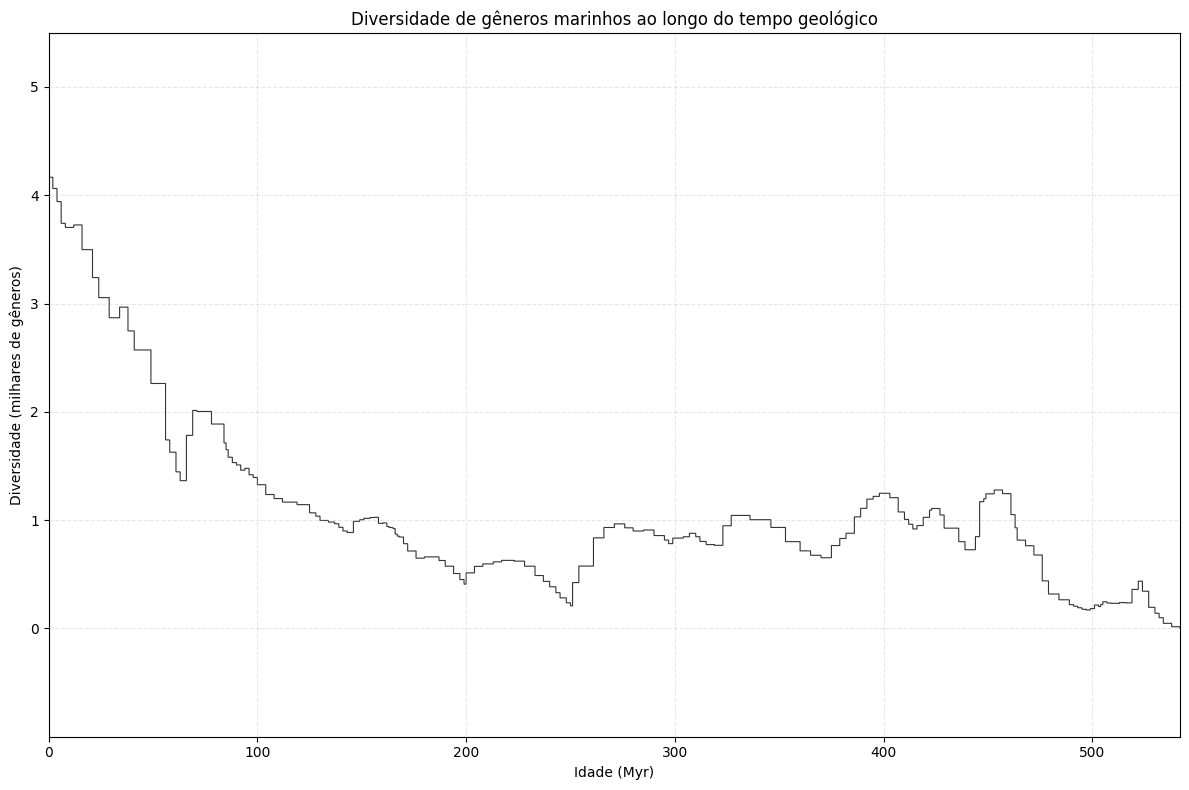

✓ Gráfico salvo: etapa1_diversidade_generos.png


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Diversidade de gêneros marinhos ao longo do tempo geológico'}, xlabel='Idade (Myr)', ylabel='Diversidade (milhares de gêneros)'>)

In [133]:
# Eixo y: Diversidade de gêneros marinhos ao longo do tempo geológico, em milhares de gêneros.
y = df["Diversity"] / 1000

# Plotagem da série temporal
plotar_serie_temporal(x, y, 
                     "Diversidade de gêneros marinhos ao longo do tempo geológico",
                     "etapa1_diversidade_generos.png")

### Análise Inicial

**Observações:**
- Tendência decrescente nos primeiros 80 Myr
- Picos notáveis: ~80, ~280-450, ~500 Myr
- Vales: ~100-250, ~450-500 Myr
- Possíveis padrões cíclicos superpostos à tendência

Estas variações sugerem flutuações periódicas que serão investigadas por análise espectral.

## Etapa 2 - Remoção da Tendência

Para isolar flutuações periódicas, ajustamos polinômio de grau 3 removendo tendência de longo prazo.




✓ Polinômio grau 3 ajustado (R² = 0.947)


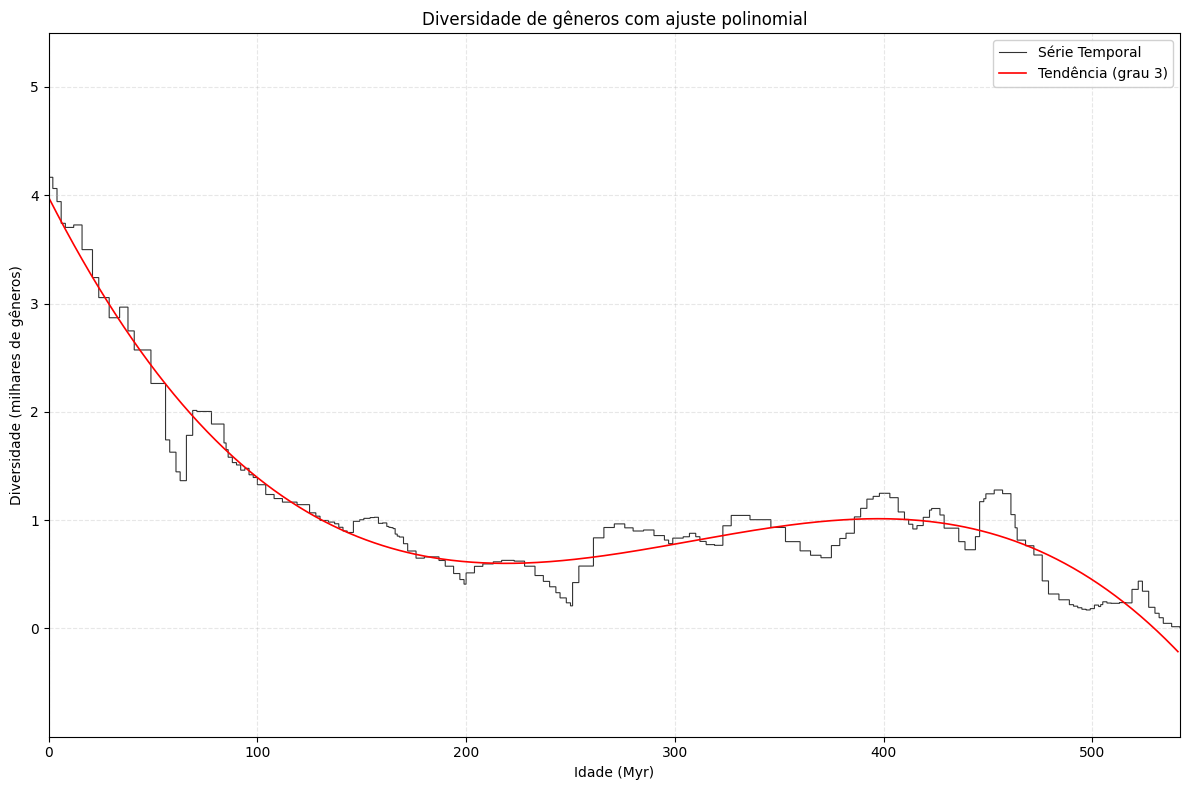

✓ Gráfico salvo: etapa2_remocao_tendencia.png


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Diversidade de gêneros com ajuste polinomial'}, xlabel='Idade (Myr)', ylabel='Diversidade (milhares de gêneros)'>)

In [134]:
# Eixo x: Idade geológica em milhões de anos (Myr).
x = df["TimeBin"]
# Eixo y: Diversidade de gêneros marinhos ao longo do tempo geológico, em milhares de gêneros.
y = df["Diversity"] / 1000

# Ajuste polinomial para remoção de tendência
polynomial = ajustar_polinomio(y, grau=3)

# Plotagem com tendência
plotar_serie_temporal(x, y,
                     "Diversidade de gêneros com ajuste polinomial",
                     "etapa2_remocao_tendencia.png",
                     polynomial=polynomial)

### Cálculo dos Resíduos
Subtraímos a tendência para obter resíduos apropriados para análise espectral.

✓ Resíduos calculados
  - Média: -0.0000
  - Desvio padrão: 0.1862
  - Amplitude: 1.1556


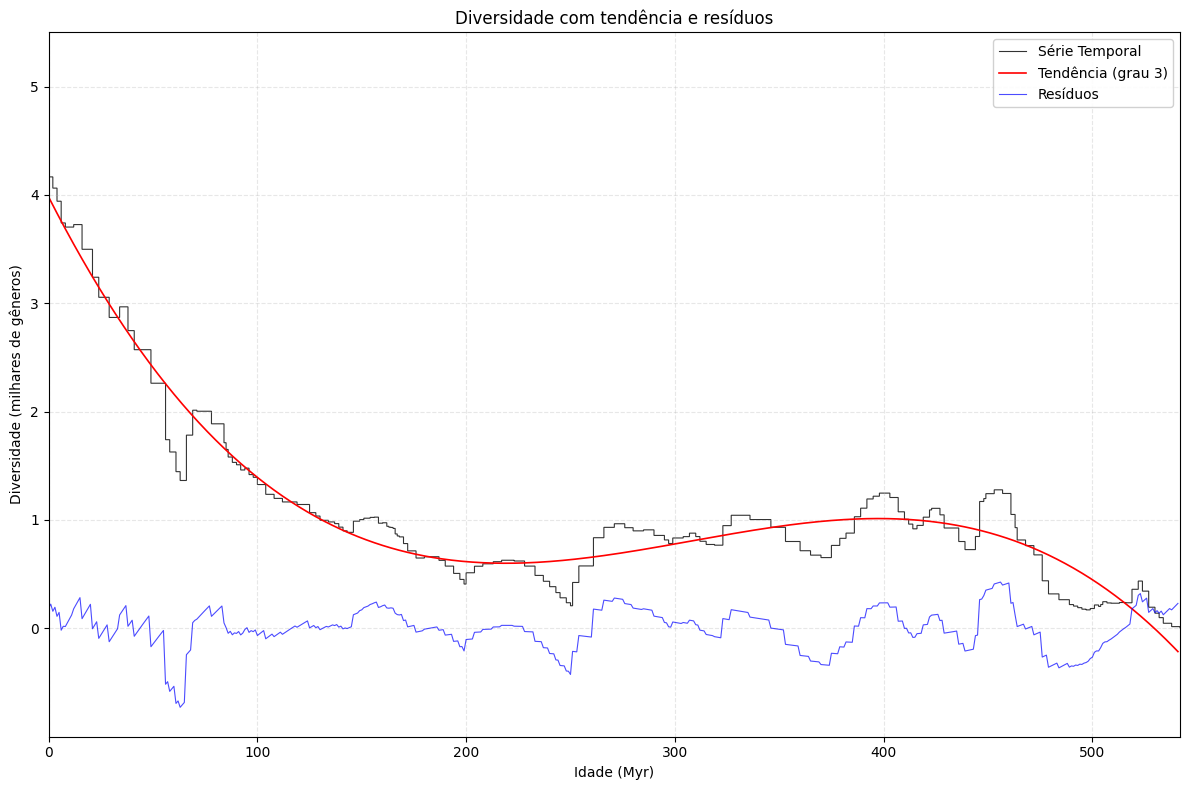

✓ Gráfico salvo: etapa2_residuos.png


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Diversidade com tendência e resíduos'}, xlabel='Idade (Myr)', ylabel='Diversidade (milhares de gêneros)'>)

In [135]:
# Cálculo dos resíduos
residuos = calcular_residuos(y, x, polynomial)

# Plotagem com tendência e resíduos
plotar_serie_temporal(x, y,
                     "Diversidade com tendência e resíduos",
                     "etapa2_residuos.png",
                     polynomial=polynomial,
                     residuals=residuos)

## Etapa 3 - Análise Espectral

Aplicamos FFT aos resíduos para decompor a série em diferentes frequências e identificar oscilações periódicas.

✓ Espectro calculado
  - Pontos espectrais: 27
  - Padding aplicado: 1x
  - Janela: Nenhuma
  - Resolução: 0.001845 ciclos/Myr


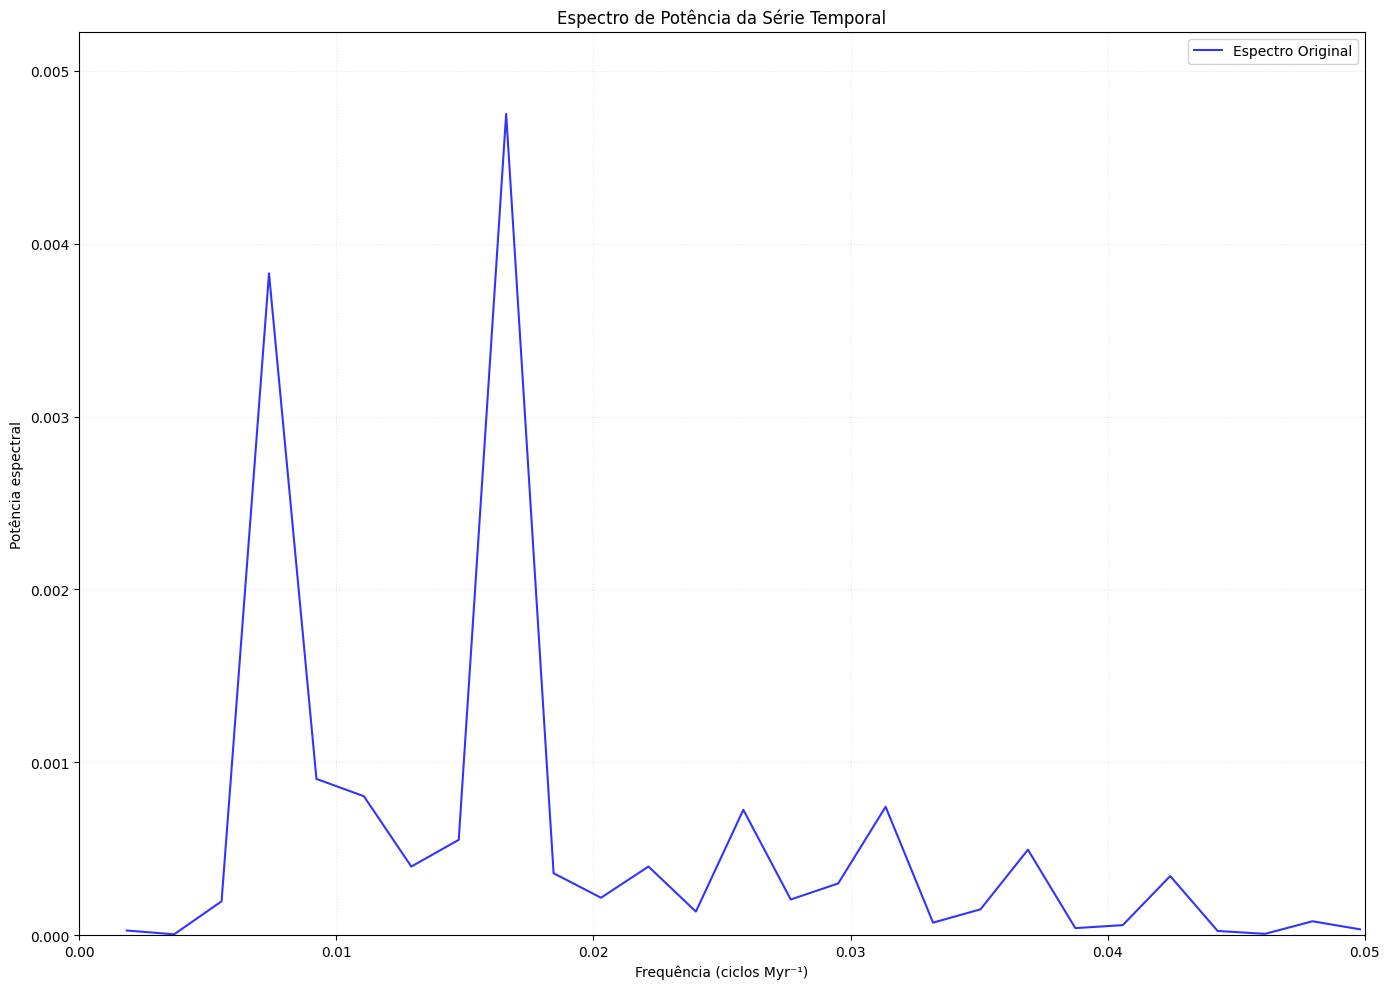

✓ Espectro salvo: etapa3_espectro_potencia.png


(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Espectro de Potência da Série Temporal'}, xlabel='Frequência (ciclos Myr⁻¹)', ylabel='Potência espectral'>)

In [136]:
# Aplicação da FFT aos resíduos
freqs, pots = calcular_espectro_potencia(residuos)

# Plotagem do espectro de potência
plotar_espectro_potencia(freqs, pots,
                        'Espectro de Potência da Série Temporal',
                        'etapa3_espectro_potencia.png')

### Refinamento do Espectro
Aplicamos padding (fator 7) para melhorar resolução espectral.

✓ Espectro calculado
  - Pontos espectrais: 189
  - Padding aplicado: 7x
  - Janela: Nenhuma
  - Resolução: 0.000264 ciclos/Myr


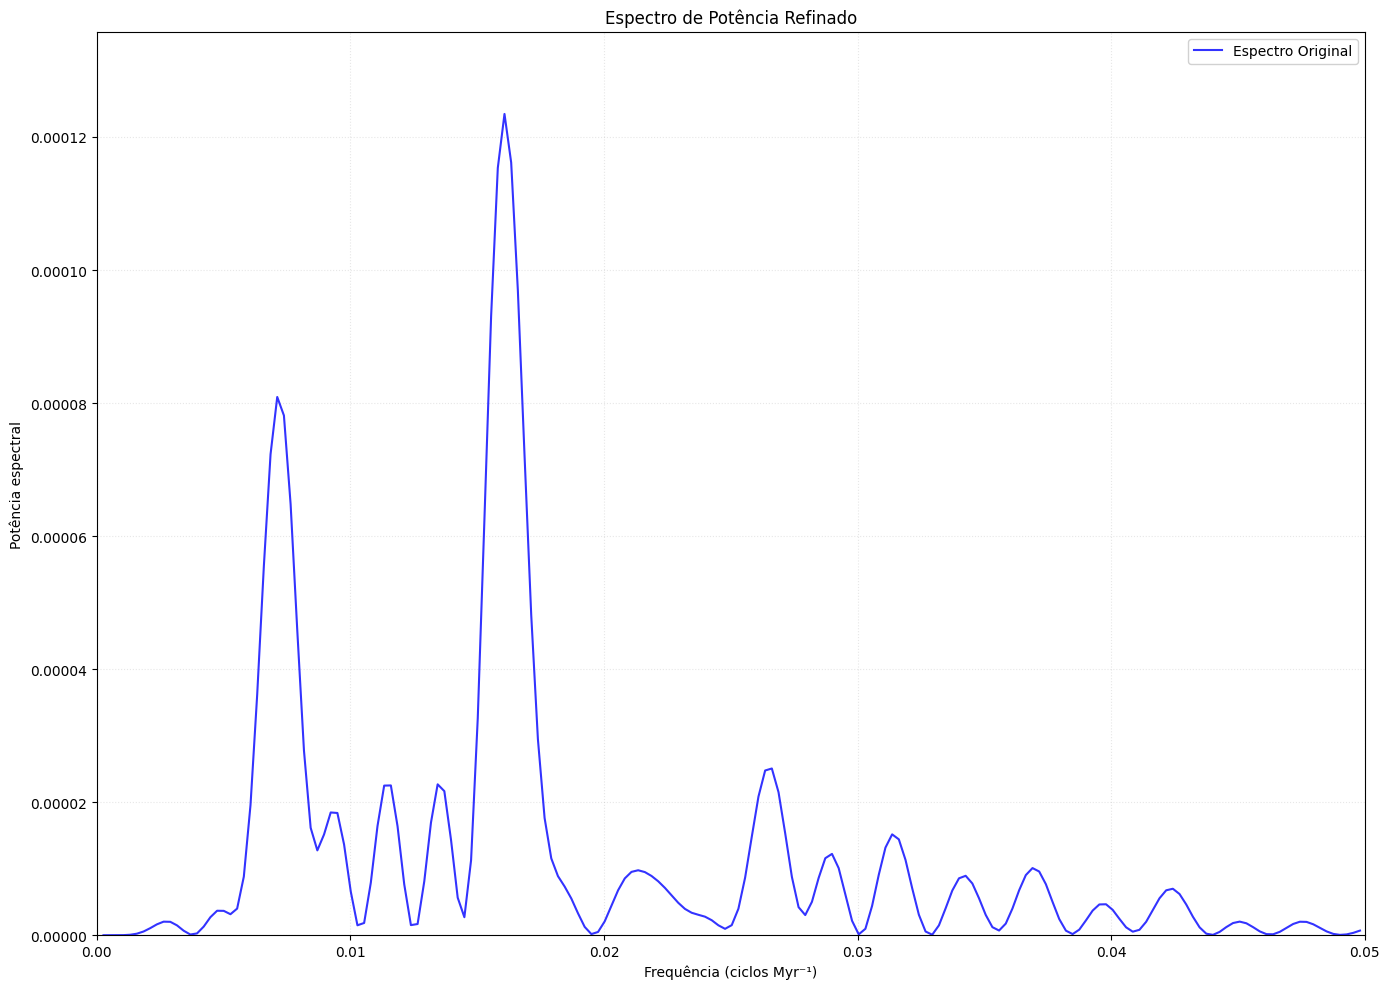

✓ Espectro salvo: etapa3_espectro_potencia_refinado.png


(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Espectro de Potência Refinado'}, xlabel='Frequência (ciclos Myr⁻¹)', ylabel='Potência espectral'>)

In [137]:
# FFT com padding para melhor resolução
freqs_ref, pots_ref = calcular_espectro_potencia(residuos, pad=7)

# Plotagem do espectro refinado
plotar_espectro_potencia(freqs_ref, pots_ref,
                        'Espectro de Potência Refinado',
                        'etapa3_espectro_potencia_refinado.png')

### Identificação de Picos
Picos relevantes são identificados com threshold de 25% da potência máxima.


✓ Análise de picos concluída
  - Threshold: 0.000031 (25% do máximo)
  - Picos encontrados: 2

  📊 Picos identificados:
  --------------------------------------------------
   1. Período:  140.5 Myr | Freq: 0.0071 | Potência: 0.000081
   2. Período:   62.2 Myr | Freq: 0.0161 | Potência: 0.000123


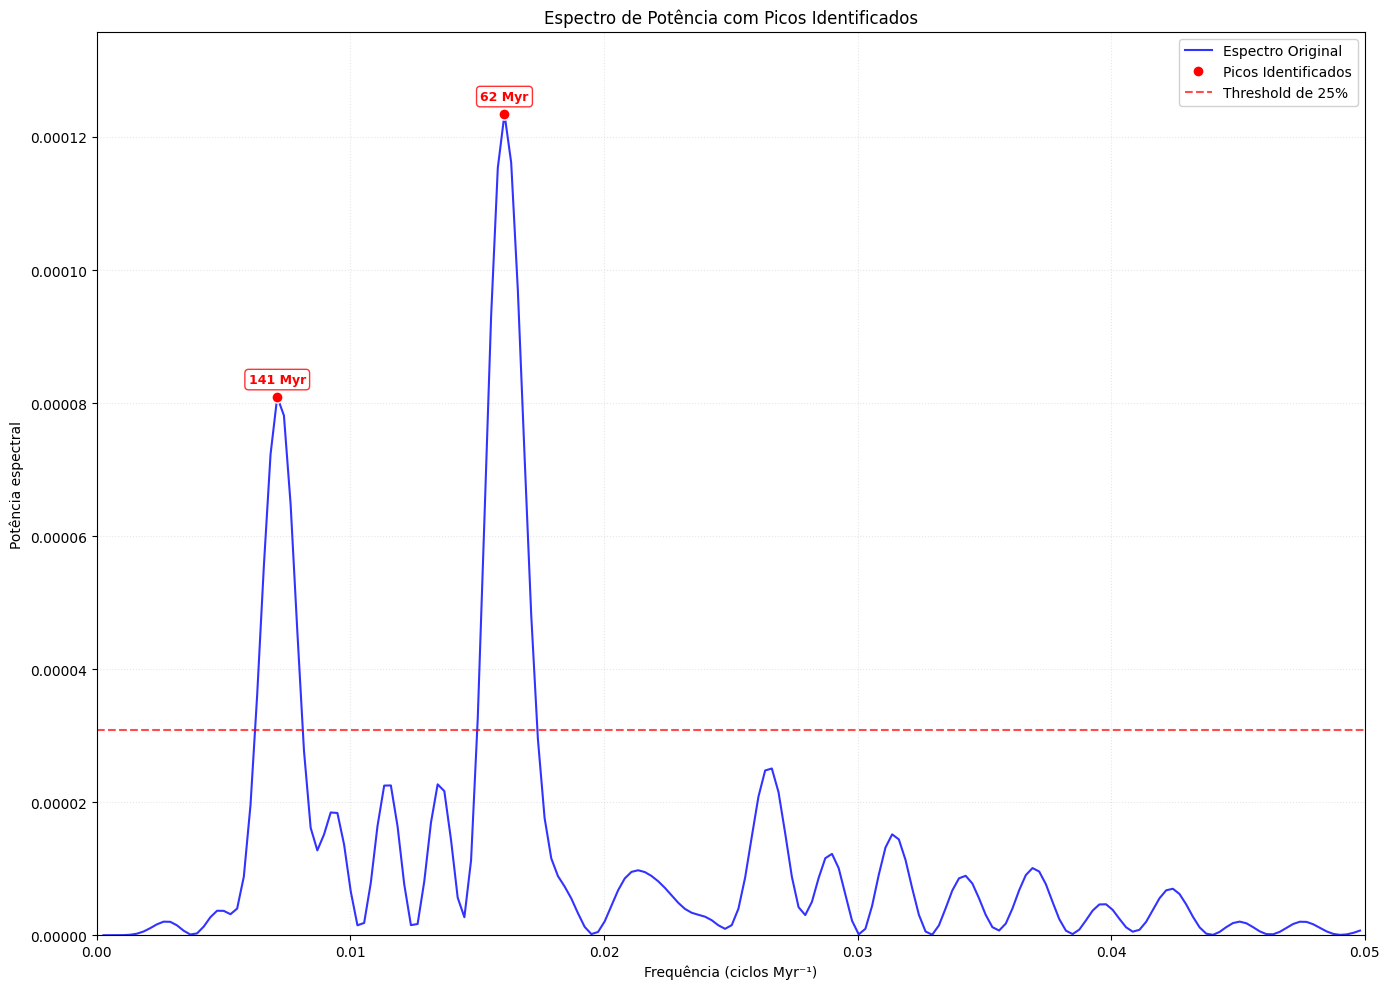

✓ Espectro salvo: etapa3_espectro_com_picos_threshold_25.png


(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Espectro de Potência com Picos Identificados'}, xlabel='Frequência (ciclos Myr⁻¹)', ylabel='Potência espectral'>)

In [138]:
# Identificação de picos com threshold de 25%
picos, properties, threshold = identificar_picos_espectrais(freqs_ref, pots_ref, threshold_frac=0.25)

# Plotagem com picos identificados
plotar_espectro_potencia(freqs_ref, pots_ref,
                        'Espectro de Potência com Picos Identificados',
                        'etapa3_espectro_com_picos_threshold_25.png',
                        picos=picos,
                        threshold=threshold)

**Resultado:** Dois picos relevantes identificados em 62 e 141 Myr.

## Etapa 4 - Modelos Nulos (Monte Carlo)

Testamos significância dos picos com simulações que preservam características estatísticas dos dados originais.

**Estratégia:** Dois modelos complementares:
- **Modelo R:** Embaralhamento de incrementos (passeio aleatório)
- **Modelo W:** Embaralhamento de blocos (preserva autocorrelações locais)

### Modelo R (Red Noise)

**Conceito:** Simula passeio aleatório embaralhando incrementos.

**Testa:** Se padrões são resultado de deriva aleatória (preserva distribuição dos incrementos, remove ordem temporal).


EXECUTANDO MODELO R
🔄 Executando Modelo R: 1000 simulações
   Incrementos originais: 541
   Média dos incrementos: 0.0001
   Desvio dos incrementos: 0.0573
   • Progresso: 200/1000 (20.0%)
   • Progresso: 400/1000 (40.0%)
   • Progresso: 600/1000 (60.0%)
   • Progresso: 800/1000 (80.0%)
   • Progresso: 1000/1000 (100.0%)
   ✓ Modelo R concluído: 1000 simulações geradas
📊 Calculando espectros: 1000 séries
   Padding aplicado: 7x
✓ Polinômio grau 3 ajustado (R² = 0.426)
✓ Resíduos calculados
  - Média: 0.0000
  - Desvio padrão: 0.2681
  - Amplitude: 1.1780
✓ Espectro calculado
  - Pontos espectrais: 189
  - Padding aplicado: 7x
  - Janela: Nenhuma
  - Resolução: 0.000264 ciclos/Myr
✓ Polinômio grau 3 ajustado (R² = 0.657)
✓ Resíduos calculados
  - Média: -0.0000
  - Desvio padrão: 0.2063
  - Amplitude: 1.2213
✓ Espectro calculado
  - Pontos espectrais: 189
  - Padding aplicado: 7x
  - Janela: Nenhuma
  - Resolução: 0.000264 ciclos/Myr
✓ Polinômio grau 3 ajustado (R² = 0.728)
✓ Resíduos 

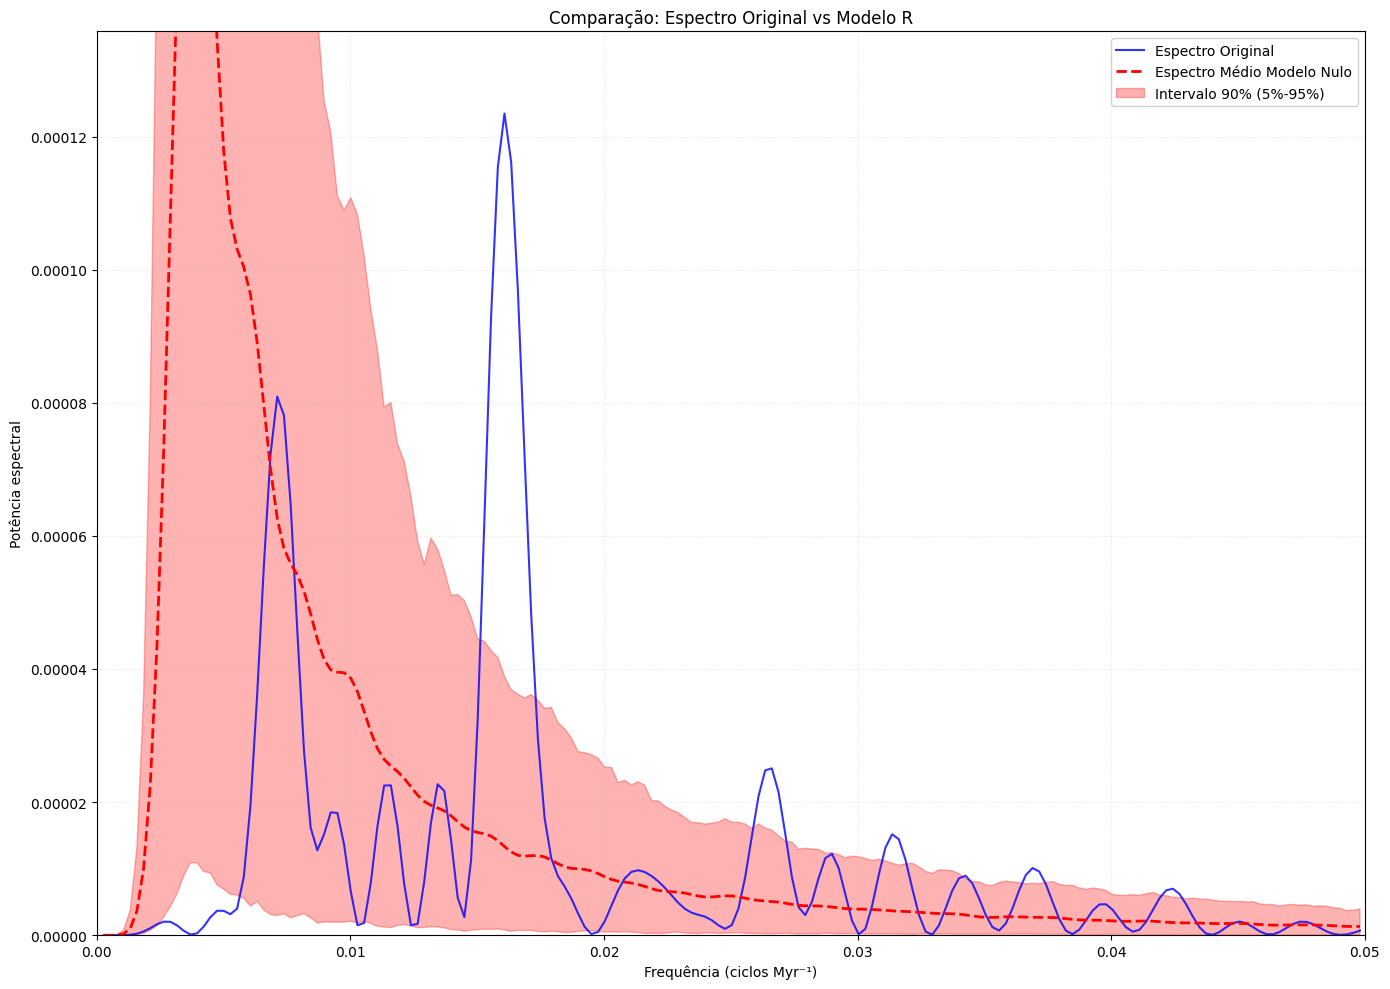

✓ Espectro salvo: etapa4_modelo_r_espectro_medio.png
Processamento concluído! Média de 1000 espectros calculada.


In [139]:
# Execução do Modelo R
resultados_r = executar_modelo_nulo_completo(
    residuos, tipo_modelo='R', n_simulacoes=1000
)

# Extrair resultados do dicionário
freqs_r = resultados_r['freqs']
espectro_medio_r = resultados_r['espectro_medio']
intervalo_confianca_r = resultados_r['intervalo_confianca']
todos_espectros_r = resultados_r['espectros_individuais']

# Plotagem da comparação
plotar_espectro_potencia(freqs_ref, pots_ref,
                        'Comparação: Espectro Original vs Modelo R',
                        'etapa4_modelo_r_espectro_medio.png',
                        freqs_modelo=freqs_r,
                        pots_modelo=espectro_medio_r,
                        intervalo_confianca=intervalo_confianca_r)

print(f"Processamento concluído! Média de {len(todos_espectros_r)} espectros calculada.")

### Modelo W (White Noise)

**Conceito:** Simula ruído branco embaralhando blocos contíguos.

**Testa:** Se padrões são resultado de flutuações locais (preserva autocorrelações locais, remove estruturas de longo prazo).


EXECUTANDO MODELO W
🔄 Executando Modelo W: 1000 simulações
   Tamanho do bloco: 10
   Número de blocos: 55
   Pontos por simulação: 542
   • Progresso: 200/1000 (20.0%)
   • Progresso: 400/1000 (40.0%)
   • Progresso: 600/1000 (60.0%)
   • Progresso: 400/1000 (40.0%)
   • Progresso: 600/1000 (60.0%)
   • Progresso: 800/1000 (80.0%)
   • Progresso: 1000/1000 (100.0%)
   ✓ Modelo W concluído: 1000 simulações geradas
📊 Calculando espectros: 1000 séries
   Padding aplicado: 7x
✓ Polinômio grau 3 ajustado (R² = 0.060)
✓ Resíduos calculados
  - Média: -0.0000
  - Desvio padrão: 0.1805
  - Amplitude: 1.1526
✓ Espectro calculado
  - Pontos espectrais: 189
  - Padding aplicado: 7x
  - Janela: Nenhuma
  - Resolução: 0.000264 ciclos/Myr
✓ Polinômio grau 3 ajustado (R² = 0.010)
✓ Resíduos calculados
  - Média: 0.0000
  - Desvio padrão: 0.1852
  - Amplitude: 1.1506
✓ Espectro calculado
  - Pontos espectrais: 189
  - Padding aplicado: 7x
  - Janela: Nenhuma
  - Resolução: 0.000264 ciclos/Myr
✓ Poli

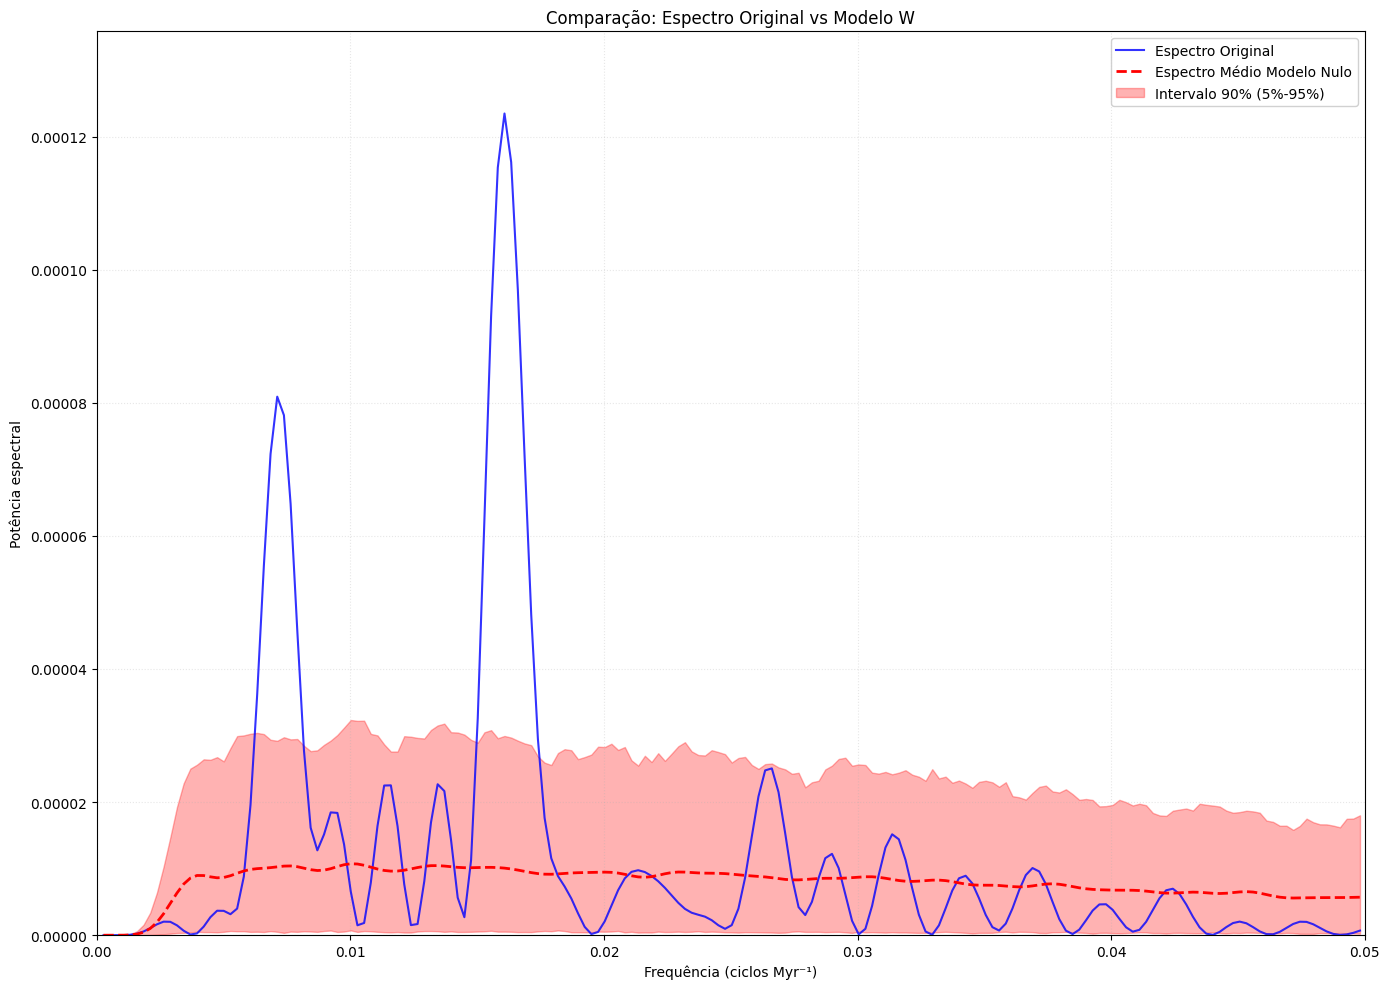

✓ Espectro salvo: etapa4_modelo_w_espectro_medio.png
Processamento concluído! Média de 1000 espectros calculada.


In [140]:
# Execução do Modelo W
resultados_w = executar_modelo_nulo_completo(
    residuos, tipo_modelo='W', n_simulacoes=1000, tamanho_bloco=10
)

# Extrair resultados do dicionário
freqs_w = resultados_w['freqs']
espectro_medio_w = resultados_w['espectro_medio']
intervalo_confianca_w = resultados_w['intervalo_confianca']
todos_espectros_w = resultados_w['espectros_individuais']

# Plotagem da comparação
plotar_espectro_potencia(freqs_ref, pots_ref,
                        'Comparação: Espectro Original vs Modelo W',
                        'etapa4_modelo_w_espectro_medio.png',
                        freqs_modelo=freqs_w,
                        pots_modelo=espectro_medio_w,
                        intervalo_confianca=intervalo_confianca_w)

print(f"Processamento concluído! Média de {len(todos_espectros_w)} espectros calculada.")

### Comparação entre Modelos

**Interpretação:**
- **Significativo em ambos:** Evidência forte de periodicidade real
- **Apenas no Modelo R:** Padrões de deriva de longo prazo
- **Apenas no Modelo W:** Padrões de estrutura local
- **Em nenhum:** Provavelmente ruído aleatório

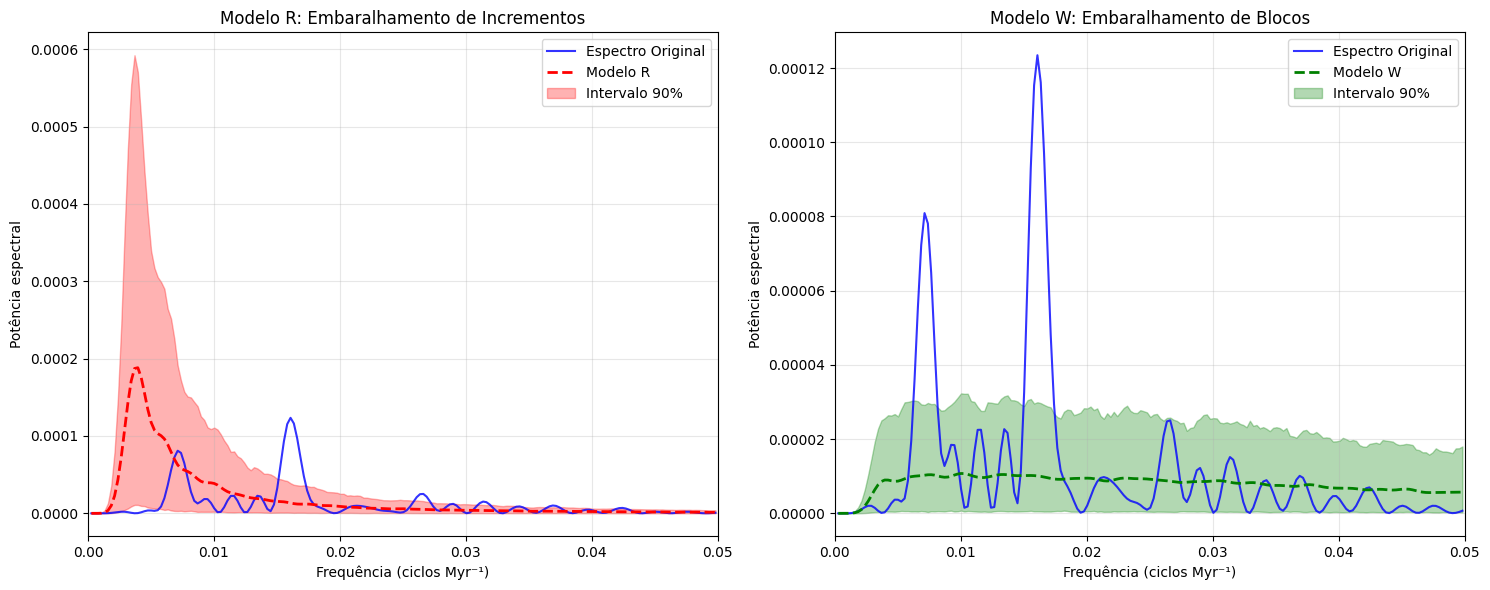

Modelos nulos gerados: R (1000 simulações) e W (1000 simulações)


In [141]:
# Comparação lado a lado dos modelos nulos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Modelo R
ax1.plot(freqs_ref, pots_ref, 'b-', linewidth=1.5, label='Espectro Original', alpha=0.8)
ax1.plot(freqs_r, espectro_medio_r, 'r--', linewidth=2, label='Modelo R')
ax1.fill_between(freqs_r, intervalo_confianca_r[0], intervalo_confianca_r[1], 
                alpha=0.3, color='red', label='Intervalo 90%')
ax1.set_title('Modelo R: Embaralhamento de Incrementos')
ax1.set_xlabel('Frequência (ciclos Myr⁻¹)')
ax1.set_ylabel('Potência espectral')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 0.05)

# Modelo W
ax2.plot(freqs_ref, pots_ref, 'b-', linewidth=1.5, label='Espectro Original', alpha=0.8)
ax2.plot(freqs_w, espectro_medio_w, 'g--', linewidth=2, label='Modelo W')
ax2.fill_between(freqs_w, intervalo_confianca_w[0], intervalo_confianca_w[1], 
                alpha=0.3, color='green', label='Intervalo 90%')
ax2.set_title('Modelo W: Embaralhamento de Blocos')
ax2.set_xlabel('Frequência (ciclos Myr⁻¹)')
ax2.set_ylabel('Potência espectral')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 0.05)

plt.tight_layout()
plt.savefig(str(RESULTS_PATH / "etapa4_comparacao_modelos_nulos.png"), dpi=300, bbox_inches="tight")
plt.show()

print(f"Modelos nulos gerados: R ({len(todos_espectros_r)} simulações) e W ({len(todos_espectros_w)} simulações)")

### Conclusão da Etapa 4

**Resultados:** Dois modelos nulos com 1.000 simulações cada, espectros médios e intervalos de confiança (90%) calculados.

**Próxima etapa:** Teste de significância dos picos identificados.

## Etapa 5 - Teste de Significância

Testamos significância estatística dos picos comparando-os com modelos nulos (critério: 95% de confiança em ambos os modelos).

In [142]:
# Executar testes de significância
resultados_r, resultados_w = comparar_modelos_nulos(
    freqs_ref, pots_ref, picos,
    todos_espectros_r, freqs_r,
    todos_espectros_w, freqs_w
)

# Gerar relatório final
picos_significativos = criar_relatorio_final(resultados_r, resultados_w)

=== COMPARAÇÃO DE SIGNIFICÂNCIA ENTRE MODELOS ===

MODELO R (Embaralhamento de Incrementos):
--------------------------------------------------
Pico 1: Período = 140.5 Myr
  Potência observada: 0.000081
  Percentil no modelo nulo: 26.7%
  Significância: 73.3%
  Significativo (95%): Não

Pico 2: Período = 62.2 Myr
  Potência observada: 0.000123
  Percentil no modelo nulo: 0.0%
  Significância: 100.0%
  Significativo (95%): Sim

MODELO W (Embaralhamento de Blocos):
--------------------------------------------------
Pico 1: Período = 140.5 Myr
  Potência observada: 0.000081
  Percentil no modelo nulo: 0.0%
  Significância: 100.0%
  Significativo (95%): Sim

Pico 2: Período = 62.2 Myr
  Potência observada: 0.000123
  Percentil no modelo nulo: 0.0%
  Significância: 100.0%
  Significativo (95%): Sim

=== RESUMO COMPARATIVO ===
Período (Myr) Modelo R (%) Modelo W (%) Consenso  
--------------------------------------------------
140.5        73.3         100.0        Não       
62.2         10

## Etapa 6 - Discussão e Interpretação

### Metodologia Aplicada

1. **Remoção de Tendência:** Ajuste polinomial grau 3
2. **Análise Espectral:** FFT com padding para melhor resolução
3. **Modelos Nulos:** Dois modelos complementares (R e W) 
4. **Teste Estatístico:** Critério de 95% de confiança em ambos

### Implicações Científicas

Períodos identificados podem estar relacionados a:
- Ciclos climáticos de longo prazo
- Variações na atividade tectônica  
- Impactos extraterrestres periódicos
- Ciclos de extinção e radiação adaptativa

### Conclusão

A utilização de dois modelos nulos distintos e exigência de significância em ambos garante robustez estatística, demonstrando a utilidade de métodos espectrais rigorosos na detecção de padrões periódicos em dados paleobiológicos.

In [143]:
# ============================
# RESUMO EXECUTIVO DA ANÁLISE
# ============================

print("\n" + "=" * 70)
print("RESUMO EXECUTIVO - DETECÇÃO DE SINAIS PERIÓDICOS")
print("=" * 70)

print(f"\nDataset analisado: {len(df)} pontos temporais ({x.min():.0f}-{x.max():.0f} Myr)")
print(f"Método: Análise espectral por FFT com modelos nulos (Monte Carlo)")
print(f"Simulações: 1.000 para cada modelo (R e W)")
print(f"Critério: Significância de 95% em ambos os modelos")

if picos_significativos:
    print(f"\nResultado: {len(picos_significativos)} período(s) significativo(s) detectado(s)")
    for i, pico in enumerate(picos_significativos, 1):
        print(f"  {i}. Período de {pico['periodo']:.0f} Myr")
else:
    print("\nResultado: Nenhum período estatisticamente significativo detectado")

print("\nStatus: Análise concluída com sucesso")
print("=" * 70)


RESUMO EXECUTIVO - DETECÇÃO DE SINAIS PERIÓDICOS

Dataset analisado: 542 pontos temporais (0-541 Myr)
Método: Análise espectral por FFT com modelos nulos (Monte Carlo)
Simulações: 1.000 para cada modelo (R e W)
Critério: Significância de 95% em ambos os modelos

Resultado: 1 período(s) significativo(s) detectado(s)
  1. Período de 62 Myr

Status: Análise concluída com sucesso


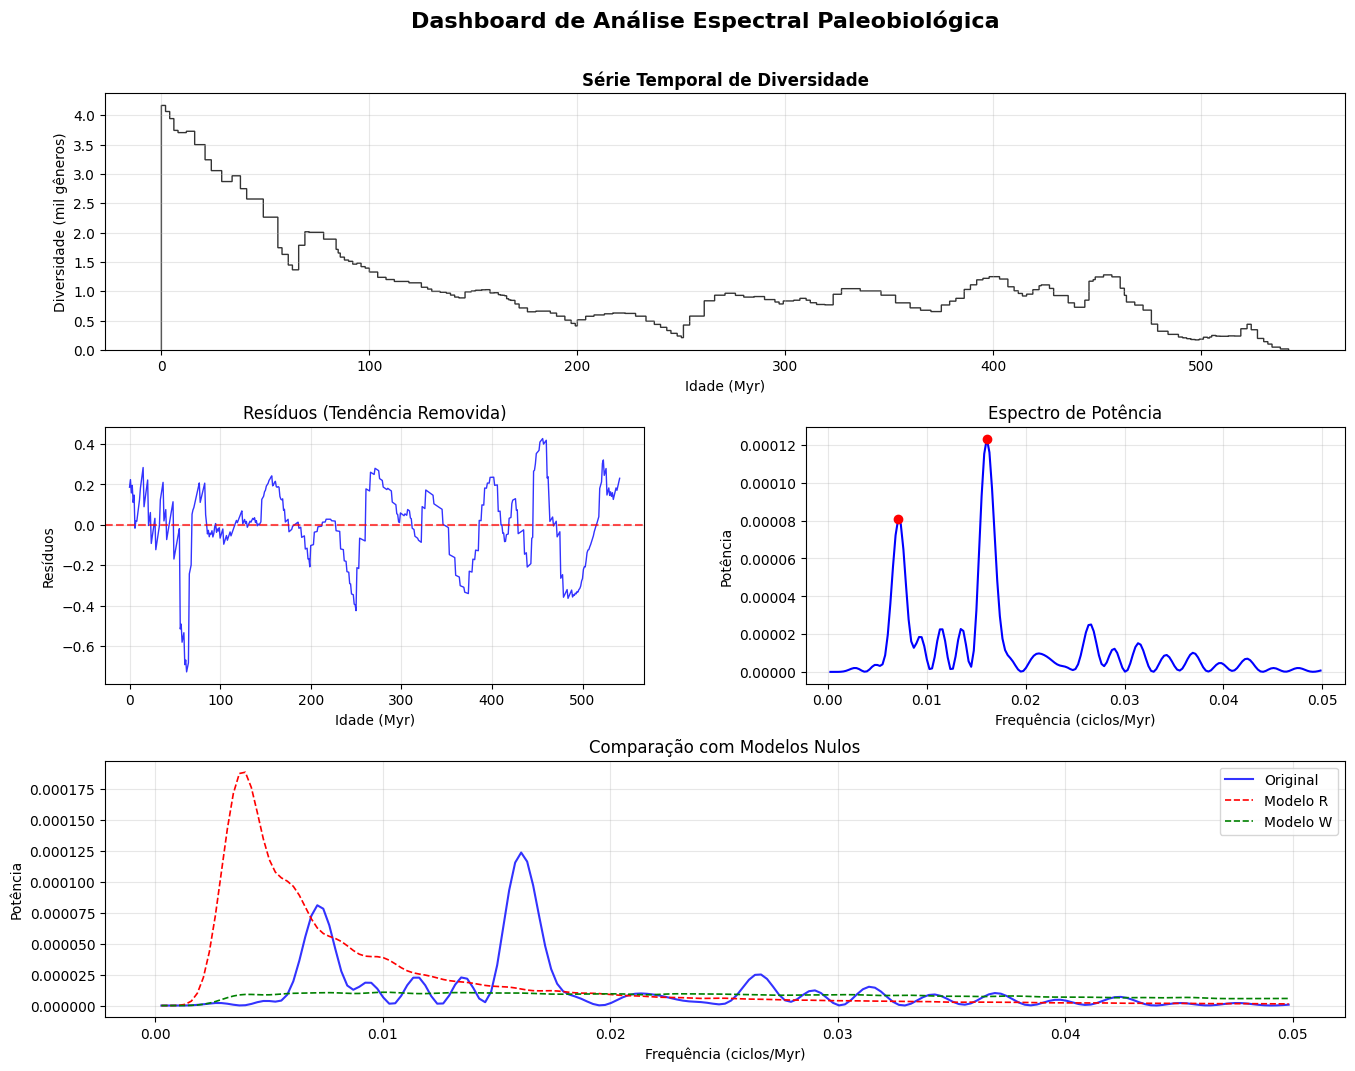

✓ Dashboard salvo: dashboard_analise_final.png

🎯 DASHBOARD FINAL CRIADO
✓ Visualização completa da análise salva
✓ Todos os resultados integrados em uma única visualização


In [ ]:
# ============================
# DASHBOARD FINAL COMPLETO
# ============================

# Preparar dados para dashboard
dados_dashboard = {
    'x': x,
    'y': y,
    'residuos': residuos,
    'freqs': freqs_ref,
    'pots': pots_ref,
    'picos': picos,
    'freqs_r': freqs_r,
    'pots_r': espectro_medio_r,
    'freqs_w': freqs_w,
    'pots_w': espectro_medio_w
}

# Criar dashboard final
fig, axes = criar_dashboard_completo(dados_dashboard, "dashboard_analise_final.png")
